# Dating S.bovis admixture

Neal Platt 2021

In [1]:
import os
import allel
import numpy as np
import loter.locanc.local_ancestry as lc
import pandas as pd
#import modin.pandas as pd
import vcf
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from itertools import groupby
import seaborn as sns
import pickle
from collections import Counter
from IPython.display import Image 
import dask.dataframe
from dask.diagnostics import ProgressBar

In [ ]:
from dask.distributed import Client
client = Client()
client

In [3]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)
os.chdir(results_dir)

## Get pop specific allele counts for use with SciKit-allel to get descriptive stats

Keep in mind that since we have so many countries we have defined populations as major "groups" in the PCA (via Kmeans). So after we get the genotype info we then compare it to the PCA results to identify each "population"

In [3]:
#read in the vcf file
filtered_callset=allel.read_vcf('filter_genotypes/ingroup_indv_and_site_filt.vcf')

#get relevant info
gt     =allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms =filtered_callset["variants/CHROM"]
samples=filtered_callset["samples"]
poss   =filtered_callset["variants/POS"]
var_ids   =filtered_callset["variants/variant_ids"]

#get the INDEX of where each chromosome begins and ends in the genotyping array.  Ex. Chr1 is from pos 1-280 in the array, Chr2 is 281-404.  
# THERE IS A DIFFERENCE BETWEEN THE INDEX (IN THE ARRAY) AND POSITION IN THE GENOME
chrom_idxs={}
uniq_chroms=np.unique(chroms)
for chrom in tqdm(uniq_chroms):
    idxs=list(np.where(chroms == chrom)[0])
    start=min(idxs)
    stop=max(idxs)
    chrom_idxs[chrom]=[start, stop]
        
# #free up some memory
# del filtered_callset

100%|██████████| 564/564 [08:56<00:00,  1.05it/s]


In [4]:
#get kmeans_pop_idxs based on the labels from the PCA

#read in pca_df since it has the pca kmeans groups
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")

#initiate list that will store the vcf idx for each sample in relation to the pca k group
kmeans_pop_idxs = defaultdict(list)   

#get samples per pop and then calculate ac
k_ac={}

#store the index in a clean dict
kmeans_pop_idxs=defaultdict(lambda: [])

#for each pop get the sample indexes and allele counts
for k in tqdm(pca_df["kmeans_label"].unique()):
   
    #get the samples for the pop
    k_samples=list(pca_df[pca_df["kmeans_label"] == k]["sample_name"])
    
    #get the indexes for each sample
    for k_sample in k_samples:
        kmeans_pop_idxs[k].append(list(samples).index(k_sample))
    
    #get the allele counts
    k_ac[k] = gt.count_alleles(subpop=kmeans_pop_idxs[k])
    

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

100%|██████████| 3/3 [01:20<00:00, 26.89s/it]


While we are at it get allele counts for an outgroup

## F3

The expected ouptuts from F3 via scikit-allel

```
f3 = Estimated value of the statistic using all data.
se = Estimated standard error.
z  = Z-score (number of standard errors from zero).
vb = Value of the statistic in each block.
vj = Values of the statistic from block-jackknife resampling
```


Is NW SH admixed?

In [99]:
f3, se, z, vb_nw, vj = allel.average_patterson_f3(k_ac["Sh (NW)"], k_ac["Sh (SE)"], k_ac["Sb"], 500, normed=True)
print("f3={}, SE={}, Z={}: f3(C: A, B = SH_NW: SH_SE, SB)".format(f3, se, z))

f3=-0.1147713696528147, SE=0.0007644922510724643, Z=-150.12757747617223: f3(C: A, B = SH_NW: SH_SE, SB)


Is SE SH admixed?

In [100]:
f3, se, z, vb_se, vj = allel.average_patterson_f3(k_ac["Sh (SE)"], k_ac["Sh (NW)"], k_ac["Sb"], 500, normed=True)
print("f3={}, SE={}, Z={}: f3(C: A, B = SH_SE: SH_NW, SB)".format(f3, se, z))

f3=0.5102330334500964, SE=0.004225118197946318, Z=120.76183660331746: f3(C: A, B = SH_SE: SH_NW, SB)


Based of the results from these analyses, Sh from NW Africa has a *significant* signature of admixture with SE SH and Sb, the same signal is _NOT_ present when comparing SE SH with NW SH and Sb

## D: ABBA BABA

The expected ouptuts from F3 via scikit-allel


```
d = Estimated value of the statistic using all data.
se = Estimated standard error.
z = Z-score (number of standard errors from zero).
vb = Value of the statistic in each block.
vj = Values of the statistic from block-jackknife resampling.
```

https://www.genetics.org/content/192/3/1065

In [179]:
Path("{}/abba_baba".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/abba_baba".format(results_dir))

In [ ]:
#get outgroup ac (S. margrebowiei)
outgroup_idxs = list(samples).index("margrebowiei_zambia_ERR310940")
out_ac =  gt.count_alleles(subpop=kmeans_pop_idxs[k])

D=0.6341401046001398, SE=0.005975343067937009, Z=106.12614161065686


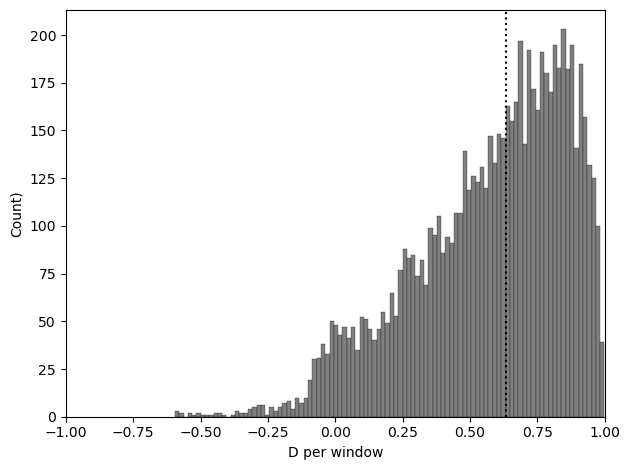

In [183]:
d, se, z, vb, vj = allel.average_patterson_d(k_ac["Sh (NW)"], k_ac["Sh (SE)"], k_ac["Sb"], out_ac, 5000)

print("D={}, SE={}, Z={}".format(d, se, z))
plt.hist(vb, bins=100, color="grey",  edgecolor="black", linewidth=0.2)
plt.xlim([-1,1])
plt.axvline(d, color = 'black', linestyle = ':')
plt.ylabel("Count)".format(k))
plt.xlabel("D per window")
plt.tight_layout()

plt.savefig("d_hist.svg".format(k))
plt.savefig("d_hist.png".format(k), dpi=300)

plt.show()

In [4]:
Path("{}/dating_admixture".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/dating_admixture".format(results_dir))

## Size distribution of Sb alleles in SH NW

In [56]:
#get kmeans labels

#read in a small loter csv file
chrom="NW_023366696.1"
tmp_df=pd.read_csv("csv_files/loter_{}.csv".format(chrom), sep=",", index_col=0)
hap_ids=tmp_df.index

#read in the pca df to get the kmeans labels (this will be used to subset the loter file into "populations")
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")

#store the kmeans labels for each HAPLOTYPE into a hap_labels dictionary
hap_labels={}
for hap_id in hap_ids:
    sample="_".join(hap_id.split("_")[:-1])
    k_label=pca_df.loc[pca_df["sample_name"]==sample]["kmeans_label"].values[0]
    hap_labels["{}_h1".format(sample)]=k_label
    hap_labels["{}_h2".format(sample)]=k_label

#now match the label with the sample in the wg df
k_labels=[]
for hap_id in tmp_df.index:
    k_labels.append(hap_labels[hap_id])

#get idxs in the df for each population
k_idxs={}    
for k_label in set(k_labels):
    #np.where returns tuple.  get rid of it
    k_idxs[k_label]=np.where(np.array(k_labels)==k_label)[0]



In [523]:
genotype_label={0: "Sh", 1: "Sb"}

#get hap block lengths per hap_id
hap_block_lengths=defaultdict(lambda: list())
csv_outs=[]

for chrom in tqdm(uniq_chroms):
    
    
    #read in loter file
#     chrom_loter_df=pd.read_csv("csv_files/loter_{}.csv".format(chrom), sep=",", index_col=0)
    chrom_loter_df=loter_chrom_dfs[chrom]
    chrom_loter_df.index.name="sample_id"

    #ignore chrom if less than 1Mb
    chrom_len=int(chrom_loter_df.columns[-1].split(":")[-1])
    if chrom_len > 1000000:
    
        #convert to 2d numpy array
        chrom_loter_numpy=chrom_loter_df.to_numpy()

        #subset on the NW S. haem
        nw_chrom_loter_numpy=np.array(chrom_loter_df.iloc[k_idxs['Sh (NW)'],])

        for i in range(0, len(nw_chrom_loter_numpy)):
            start=0
            hap_id = hap_ids[k_idxs['Sh (NW)']][i]

            hap_blocks = [(k, sum(1 for i in g)) for k,g in groupby(list(nw_chrom_loter_numpy[i]))]

            for genotype, length in hap_blocks:
                chrom, start_pos=chrom_loter_df.columns[start].split(":")
                stop_pos=chrom_loter_df.columns[start+length-1].split(":")[-1]

                #get info for a csv outfile
                csv_out="{},{},{},{},{}\n".format(hap_id, chrom, start_pos, stop_pos, genotype_label[genotype])
                csv_outs.append(csv_out)

                hap_block_length=int(stop_pos)-int(start_pos)+1
                if hap_block_length < 0:
                    print("error; {} {}", chrom, hap_id)
                    break
                if genotype_label[genotype] == "Sb":
                    hap_block_lengths[hap_id].append(hap_block_length)

                start+=length
        
#save block info as a csv for downstream processing
with open("sb_hap_blocks_chr_gt_1mb.csv",'w') as out_f:
    for entry in csv_outs:
        out_f.write(entry)
        
# save as a pickle
hap_block_lengths=dict(hap_block_lengths)
with open('sb_hap_block_lengths_chr_gt_1mb.pickle', 'wb') as handle:
    pickle.dump(hap_block_lengths, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #read in pickle if needed
# with open('hap_block_lengths.pickle', 'rb') as handle:
#     test = pickle.load(handle)

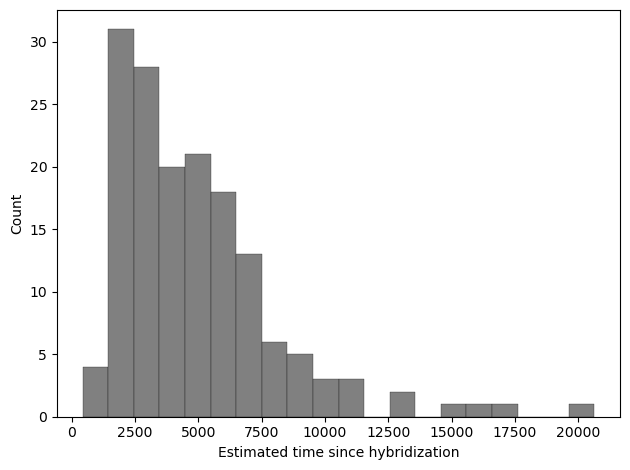

Mean time since hybridization in the NW African metapopulation is: 4918.665045086211
Min time since hybridization in the NW African metapopulation is: 421.5595272730728


In [522]:
indv_df=pd.read_csv("perc_bovis_per_indiv.csv", sep=",")

gs=[]
#get dates from introgression tract lengths
for hap_id in hap_block_lengths.keys():
    l=np.mean(hap_block_lengths[hap_id])
    p=indv_df[indv_df["sample_id"]==hap_id]["perc_bovis"].values[0]
    
    #calc from schumer paper
    # recomb rate from Sm.
    g=1/((l*3.4e-8)*p)
    gs.append(g)

plt.hist(gs, bins=20, color="grey",  edgecolor="black", linewidth=0.2)
plt.ylabel("Count".format(k))
plt.xlabel("Estimated num generations since hybridization")
plt.tight_layout()

plt.savefig("gens_since_hybridization_from_blocks.svg".format(k))
plt.savefig("gens_since_hybridization_from_blocks.png".format(k), dpi=300)
plt.show()

print("Mean time since hybridization in the NW African metapopulation is: {}".format(np.mean(gs)))
print("Min time since hybridization in the NW African metapopulation is: {}".format(np.min(gs)))

In [ ]:
# import seaborn as sns

# sns.distplot(flights['arr_delay'], hist=True, kde=True, 
#              bins=int(180/5), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

# #see https://seaborn.pydata.org/tutorial/distributions.html

In [524]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [536]:
from scipy import stats


In [585]:
x=hap_block_lengths['Sh_NG_eb_6_2_h1']
logx=np.log10(hap_block_lengths['Sh_NG_eb_6_2_h1'])

In [583]:
stats.skew(logx)

0.5219444526949897

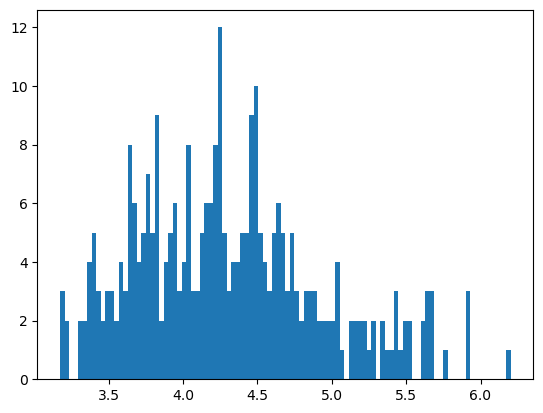

In [584]:
#plt.hist(x, 100)
counts, bins, bars = plt.hist(logx, 100)

plt.show()

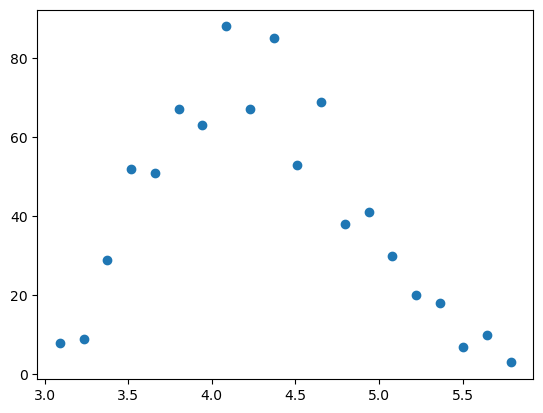

In [599]:
counts, bins, bars = plt.hist(logx, 20)
plt.clf()
plt.scatter(bins[:-1], counts)
plt.show()

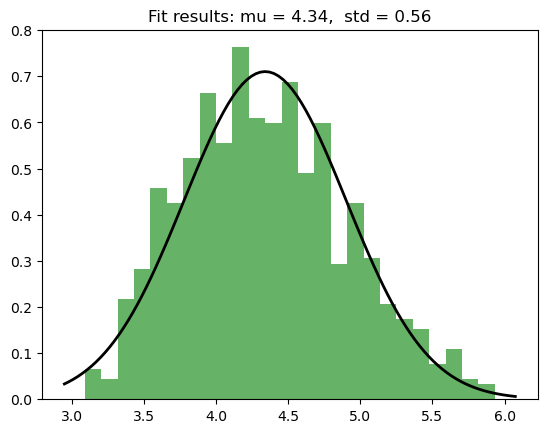

In [610]:
from scipy.stats import norm
mu, std = norm.fit(logx)
plt.hist(logx, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)


p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [543]:
from statsmodels.graphics.gofplots import qqplot
qqplot(x)
plot.show

AttributeError: 'list' object has no attribute 'shape'

In [571]:
len(x)

808

In [ ]:
from scipy.stats import shapiro
# normality test

nw_samples=list(pca_df[pca_df["kmeans_label"]=="Sh (NW)"]["sample_name"])
failed=0
accept=0
for sample_id in nw_samples:

    hap_1="_".join([sample_id, "h1"])
    hap_2="_".join([sample_id, "h2"])
    
    blocks=np.append(hap_block_lengths[hap_1], hap_block_lengths[hap_2])
    log_blocks=np.log10(blocks)

    
    stat, p = shapiro(log_blocks)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        #print('Sample {} looks Gaussian (fail to reject H0)'.format(hap_id))
        accept+=1
    else:
        failed+=1
        count, bins, bars = plt.hist(log_blocks)
        plt.title(sample_id)
        plt.show()
        #plt.clf()
        


In [646]:
accept / (failed + accept)

0.3924050632911392

In [641]:
len(np.append(hap_block_lengths[hap_1], hap_block_lengths[hap_2]))

211

In [643]:
len(hap_block_lengths[hap_2])

76

In [558]:
from scipy.stats import normaltest

stat, p = normaltest(logx)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=20.522, p=0.000
Sample does not look Gaussian (reject H0)


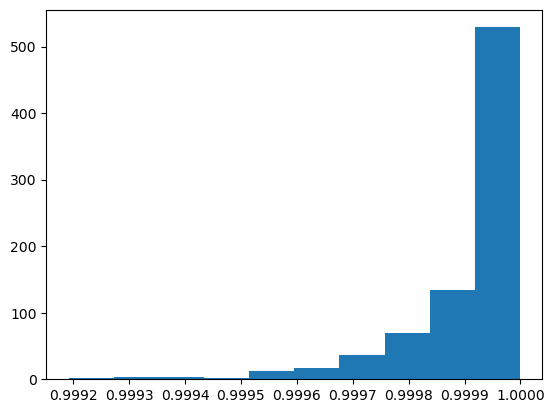

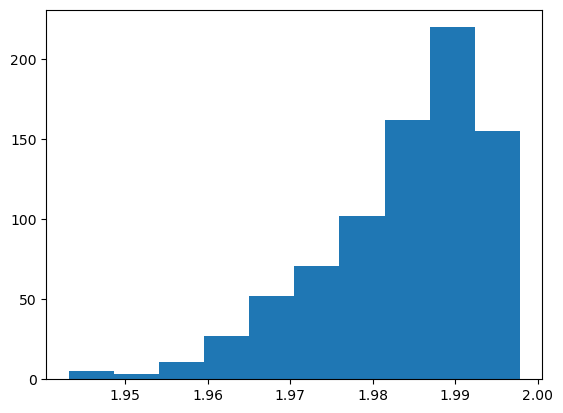

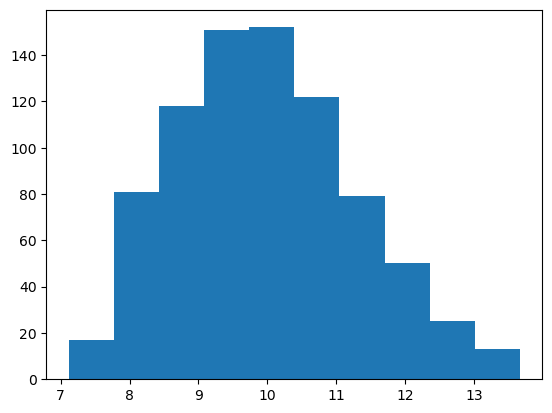

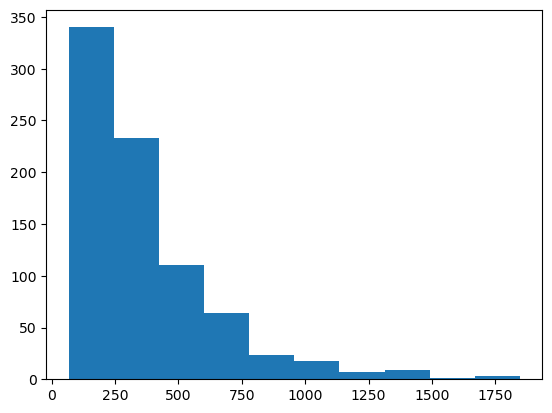

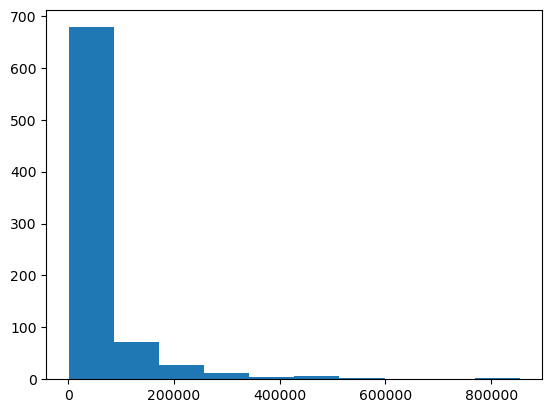

In [561]:
from scipy.stats import boxcox

for i in [-1, -0.5, 0, 0.5, 1]:
    data = boxcox(x, i)
    plt.hist(data)
    plt.show()



In [564]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import anderson

# normality test
result = anderson(logx[0:500])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))


Statistic: 1.045
15.000: 0.571, data does not look normal (reject H0)
10.000: 0.651, data does not look normal (reject H0)
5.000: 0.781, data does not look normal (reject H0)
2.500: 0.911, data does not look normal (reject H0)
1.000: 1.083, data looks normal (fail to reject H0)


In [27]:
# Ancestry at invadolysin
#NW_023366679.1:8567548-8600607
pos = np.array([x.split(":")[1] for x in df.columns[1:]]).astype(int)

In [41]:
#(pos >= 8567548) & (pos <= 8600607)

mask=np.logical_and(pos > 8_567_548, pos < 8_600_607)
target_df=df.loc[:,df.columns[1:][mask]]

In [71]:
nw=df.iloc[k_idxs['Sh (NW)'],].sum(axis=0)
se=df.iloc[k_idxs['Sh (SE)'],].sum(axis=0)
sb=df.iloc[k_idxs['Sb'],].sum(axis=0)

In [92]:
nw_ac=nw.values[1:].astype(int)
se_ac=se.values[1:].astype(int)

In [112]:
xs=np.array([x.split(":")[1] for x in df.columns[1:]]).astype(int)

In [96]:
nw_af=nw_ac/len(k_idxs['Sh (NW)'])
se_af=se_ac/len(k_idxs['Sh (SE)'])

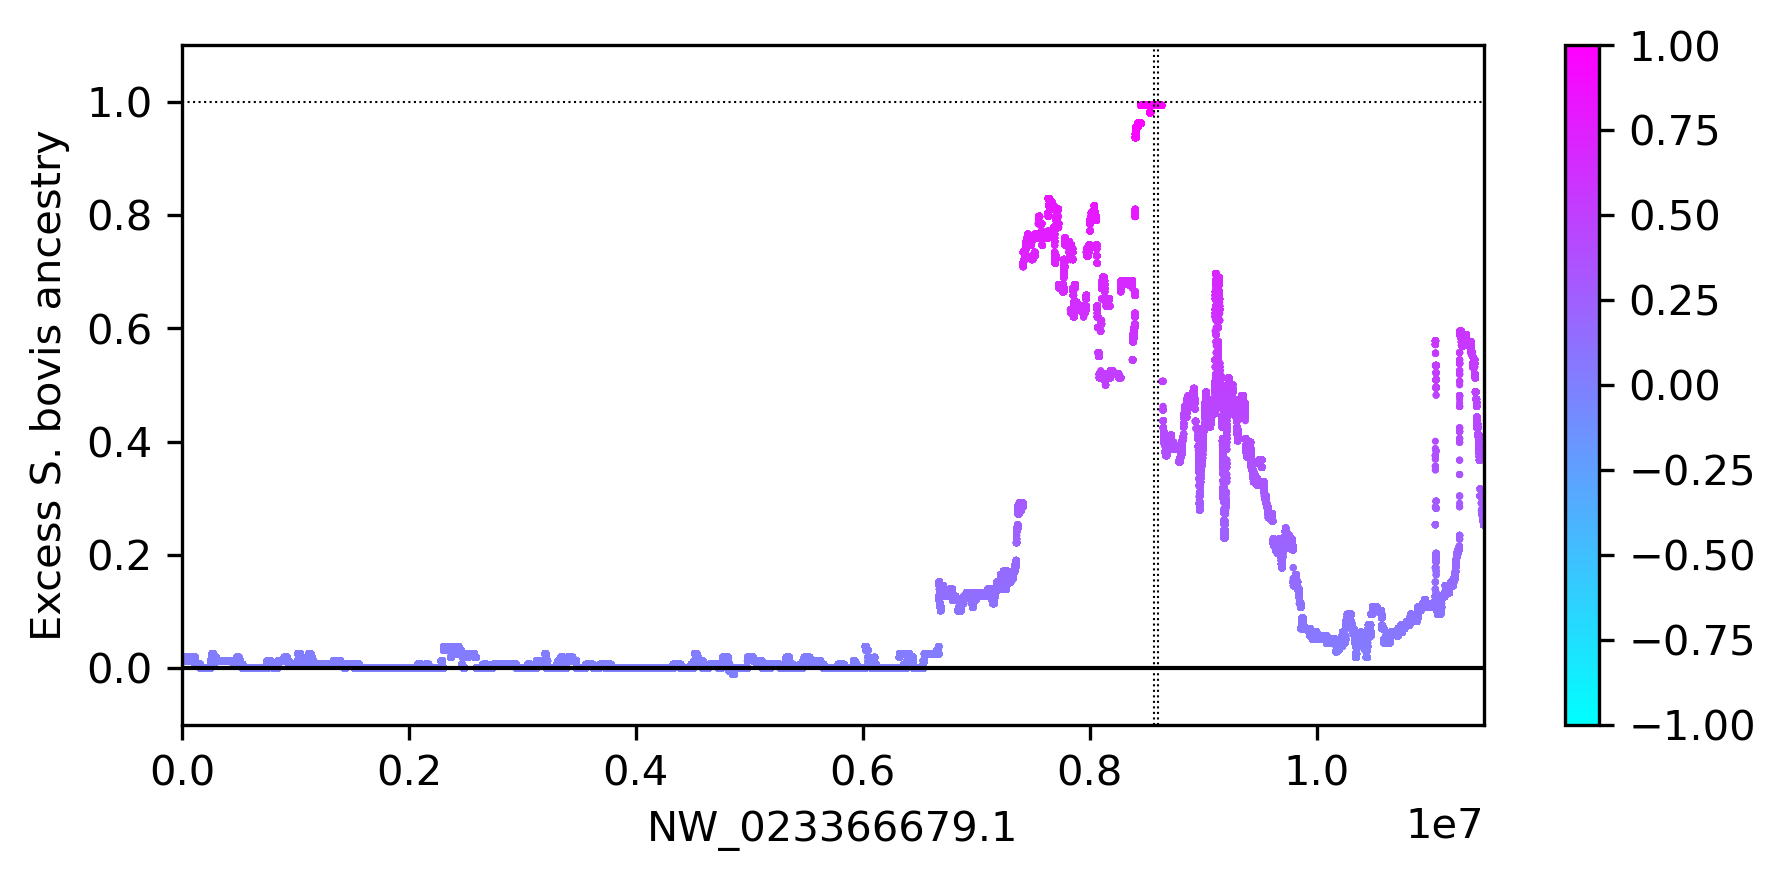

In [118]:
ys=(nw_af-se_af)
#xs=range(0,len(ys))

figure(figsize=(7, 3), dpi=300)
plt.scatter(xs, ys, c=ys, cmap="cool", s=0.5, vmin=-1, vmax=1)
plt.colorbar()
plt.ylim(-0.1, 1.1)
plt.xlim([0,xs[-1]])
plt.axhline(1,  lw=0.5, linestyle=":", c="black")
#plt.axhline(-0.95, lw=1, linestyle=":", c="black")
plt.axvline(8_567_548, lw=0.5, linestyle=":", c="black")
plt.axvline(8_600_607, lw=0.5, linestyle=":", c="black")

plt.axhline(0, lw=1, c="black")
plt.xlabel("NW_023366679.1")
plt.ylabel("Excess S. bovis ancestry")
#plt.xticks([8_567_548, 8_567_548])
#plt.tick_params(labelbottom=False, length=7) 

plt.show()
plt.close()